# Plotting the Outputs from Protein Polarisation Quantification
- *Isobel Taylor-Hearn, 2024*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patches as mpatches
from labellines import labelLine, labelLines

import warnings
warnings.filterwarnings('ignore')

In [ ]:
test = pd.read_parquet("C:\\Users\\itayl\\Dropbox (The University of Manchester)\\Python\\Soft_Stiff_Experiment\\Finished_BM_localisation\\Final_Outputs_Collagen\\updated_all_colintensity_with_distance.parquet")
bm_type = "Collagen"
test.drop('index', axis=1, inplace=True)

In [13]:
# Scale each x between 0 and 1
test['max_distance'] = test.groupby('filename').rounded_distance.transform('max')
test['min_distance'] = test.groupby('filename').rounded_distance.transform('min')
test['rounded_distance'] = (test.rounded_distance - test.min_distance) / (test.max_distance - test.min_distance)
test.rounded_distance = test.rounded_distance.apply(lambda x: round(x, 2))
test = test[test["rounded_distance"] < 0.99]
# Scale each y between 0 and 1
test = test.merge(test.groupby('filename', as_index=False).bm_intensity.max().rename(columns={'bm_intensity': 'max_intensity'}))
test.bm_intensity = test.bm_intensity / test.max_intensity
average_intensity = test.groupby(['image_type', 'rounded_distance'], as_index=False).bm_intensity.mean()
average_intensity['mean_bm_intensity'] = average_intensity.groupby('image_type')["bm_intensity"].rolling(window=2).mean().droplevel(0)
test['bm_intensity'] = test.groupby('filename')["bm_intensity"].rolling(window=1).mean().droplevel(0)


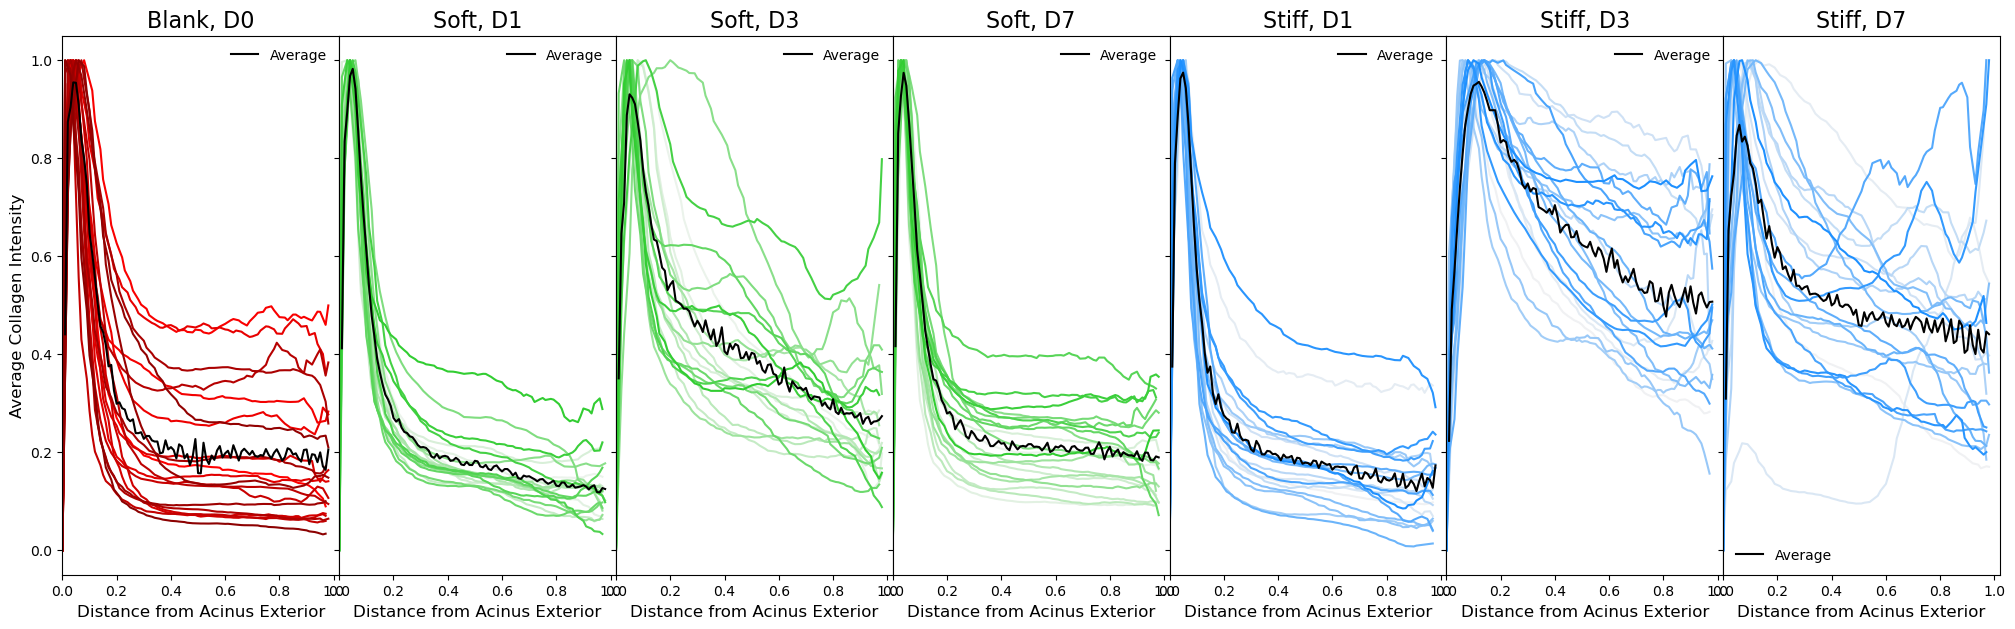

In [ ]:
gridspec = dict(hspace=0.0, wspace=0, width_ratios=[1,1,1,1,1,1,1])
fig, axs = plt.subplots(ncols = test.image_type.unique().size, figsize = (25,7),  gridspec_kw = gridspec, sharey=True)
conditions = average_intensity.image_type.unique()
for i, condition in enumerate(conditions):
    if "blank" in condition:
        my_palette = "blend:#FF0000,#8C0101"
    elif "stiff" in condition:
       my_palette="light:#1E90FF"
    elif "soft" in condition:
        my_palette="light:#32CD32"
    sns.lineplot(data=test.loc[test["image_type"]==condition], x = "rounded_distance", y="bm_intensity", palette=my_palette, hue = "filename",  ax = axs[i],  alpha = 1, legend=None)

    sns.lineplot(data=average_intensity.loc[average_intensity["image_type"]==condition], x = "rounded_distance", y="mean_bm_intensity", color="k",  ax = axs[i], label="Average")
    axs[i].set_title(condition) 
    axs[i].set_title(conditions[i].replace("_", " ").title(), fontsize=16)
    axs[i].set_xlim(0,1.02)

    for ax in axs:
        ax.set_xlabel("Distance from Acinus Exterior", fontsize=12)
        ax.set_ylabel("")
    axs[0].set_ylabel("Average {} Intensity".format(bm_type), fontsize=12)
    plt.savefig("{}_Changes.pdf".format(bm_type), bbox_inches = "tight", transparent = True)


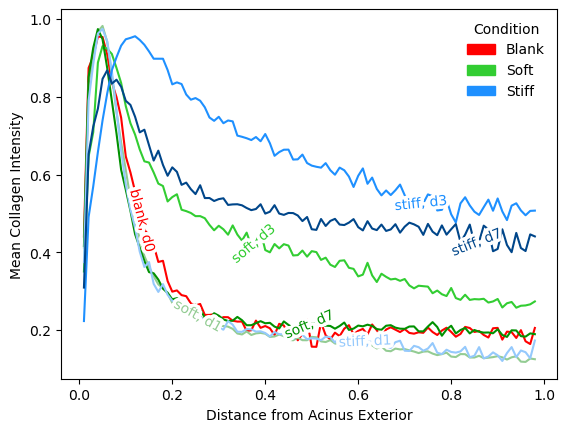

In [ ]:
fig, ax = plt.subplots()
for i, condition in enumerate(average_intensity["image_type"].unique()):
    if "d0" in condition:
        colour = "red"
    elif "d1" in condition:
        if "stiff" in condition:
            colour="#95c9fc" #lightest blue
        else:
            colour= "#93cc93" #lightest green
    elif "d3" in condition:
        if "stiff" in condition:
            colour="dodgerblue" 
        else:
            colour= "limegreen" 
    else :
        if "stiff" in condition:
            colour="#00468a"  ## darkest blue
        else:
            colour= "#019101" #darkest green
    sns.lineplot(data = average_intensity[average_intensity["image_type"]==condition], x="rounded_distance", y="mean_bm_intensity", color=colour, label=condition, legend=None)
labelLines(plt.gca().get_lines())
ax.set_ylabel("Mean {} Intensity".format(bm_type))
ax.set_xlabel("Distance from Acinus Exterior")
blank_patch = mpatches.Patch(color='red', label='Blank')
soft_patch = mpatches.Patch(color='limegreen', label='Soft')
stiff_patch = mpatches.Patch(color='dodgerblue', label='Stiff')
plt.legend(handles=[blank_patch, soft_patch, stiff_patch], title="Condition")
plt.savefig("Average_{}_Distances.pdf".format(bm_type), bbox_inches="tight", transparent=True)